# Non-negative Integration of Bulk Multi-omics Data from TCGA

This notebook demonstrates how to apply a non-negative version of `MuVI` on multiple modalities, e.g. RNA-seq, DNA methylation and RPPA, in order to infer a joint latent space that is informed a priori by existing domain knowledge in terms of gene set annotations.

In [1]:
import pandas as pd
import mudata as mu

In [2]:
import muvi

In [3]:
%matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [5]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

Load the MuData object from the `.h5mu` file:

In [6]:
mdata = mu.read("../../../data/muvi/TCGA_PRAD_BRCA.h5mu")
mdata

/home/aqoku/miniforge3/envs/muvi_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/aqoku/miniforge3/envs/muvi_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/aqoku/miniforge3/envs/muvi_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push

MuData object with n_obs × n_vars = 1539 × 20185
  obs:	'years_to_birth', 'vital_status', 'days_to_death', 'days_to_last_followup', 'gender', 'date_of_initial_pathologic_diagnosis', 'radiation_therapy', 'race', 'ethnicity', 'ctype'
  3 modalities
    rna:	1421 x 10000
      varm:	'gene_set_mask'
    methylation:	447 x 10000
    rppa:	1191 x 185

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [7]:
gene_set_collection = muvi.fs.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)
gene_set_collection

<FeatureSets 'hallmark' with 50 feature sets>

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [8]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15
)
gene_set_collection

<FeatureSets 'hallmark' with 47 feature sets>

In [9]:
for gs in gene_set_collection:
    gs.name = " ".join(gs.name.split("_")[1:]).title()[:40]

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In [10]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    mdata["rna"].var_names.tolist()
).T

Create a `MuVI` model directly from the `MuData` object by providing the necessary arguments such as the `varm` key for the numerically encoded prior information of the gene set annotations.

In [11]:
# set `nmf=True` for both views to enforce the non-negative constraint
model = muvi.tl.from_mdata(
    mdata,
    prior_mask_key="gene_set_mask",
    prior_confidence="med",
    nmf=True,
    device=device,
)
model

2024-12-16 18:00:34,039 - muvi.tools.utils - WARNING - Invalid `prior_mask_key`, `gene_set_mask` not found in `varm`.
2024-12-16 18:00:34,123 - muvi.tools.utils - WARNING - Invalid `prior_mask_key`, `gene_set_mask` not found in `varm`.
2024-12-16 18:00:34,125 - muvi.core.models - WARNING - No view names provided!
2024-12-16 18:00:34,126 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-12-16 18:00:34,423 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-16 18:00:34,424 - muvi.core.models - INFO - Storing the index of the view `methylation` as sample names.
2024-12-16 18:00:34,425 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-16 18:00:34,427 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-16 18:00:34,428 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-16 18:00:34,430 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-16 18:00:34,432 - muvi.core.models - INFO - pd.DataFrame det

|===================================================================|
|                        MuVI version 0.2.0                         |
|===================================================================|
| Parameter        | Value                                          |
|------------------|------------------------------------------------|
| n_views          | 3                                              |
| n_samples        | 1539                                           |
| n_features       | methylation: 10000, rna: 10000, rppa: 185      |
| n_factors        | 47                                             |
| prior_confidence | 0.995                                          |
| n_covariates     | 0                                              |
| likelihoods      | methylation: normal, rna: normal, rppa: normal |
| nmf              | methylation: True, rna: True, rppa: True       |
| reg_hs           | True                                           |
| pos_transform    |

In [12]:
model.fit(learning_rate=0.003, seed=0)

2024-12-16 18:00:34,826 - muvi.core.models - INFO - Preparing model and guide...
2024-12-16 18:00:34,975 - muvi.core.models - INFO - Preparing optimizer...
2024-12-16 18:00:34,977 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-12-16 18:00:34,978 - muvi.core.models - INFO - Preparing SVI...
2024-12-16 18:00:34,980 - muvi.core.models - INFO - Preparing training data...
2024-12-16 18:00:35,025 - muvi.core.models - INFO - Using complete dataset.
2024-12-16 18:00:35,071 - muvi.core.models - INFO - Setting training seed to `0`.
2024-12-16 18:00:35,081 - muvi.core.models - INFO - Cleaning parameter store.
2024-12-16 18:00:35,082 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-12-16 18:00:36,249 - root - INFO - Guessed max_plate_nesting = 2


 30%|███       | 3044/10000 [05:10<11:49,  9.80it/s, ELBO=7.91e+3]

Relative improvement of -0.0008002 < 1e-05 for 10 step(s) in a row, stopping early.
2024-12-16 18:05:45,685 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

2024-12-16 18:05:45,896 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniforge3/envs/muvi_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


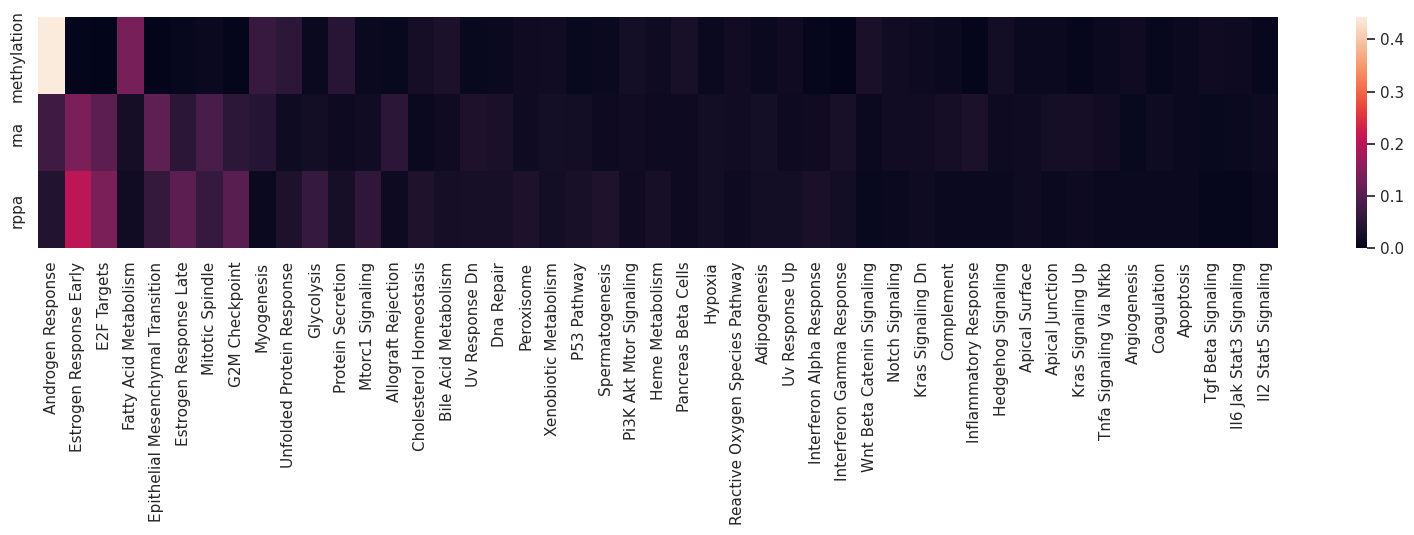

<Axes: >

In [13]:
# to speed up the process, use a random subsample to approximate the variance explained
muvi.tl.variance_explained(model)
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation. Since we only inform the RNA view, we may not apply this function on the uninformed views such as the ATAC view in our case.

In [14]:
_ = muvi.tl.test(model)

2024-12-16 18:06:14,265 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|██████████| 47/47 [00:02<00:00, 22.07it/s]

2024-12-16 18:06:16,541 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.



100%|██████████| 47/47 [00:02<00:00, 21.32it/s]


Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

For the uninformed views, i.e. ATAC, we omit any information regarding the statistical testing, and only sort the factors by their corresponding variance explained.

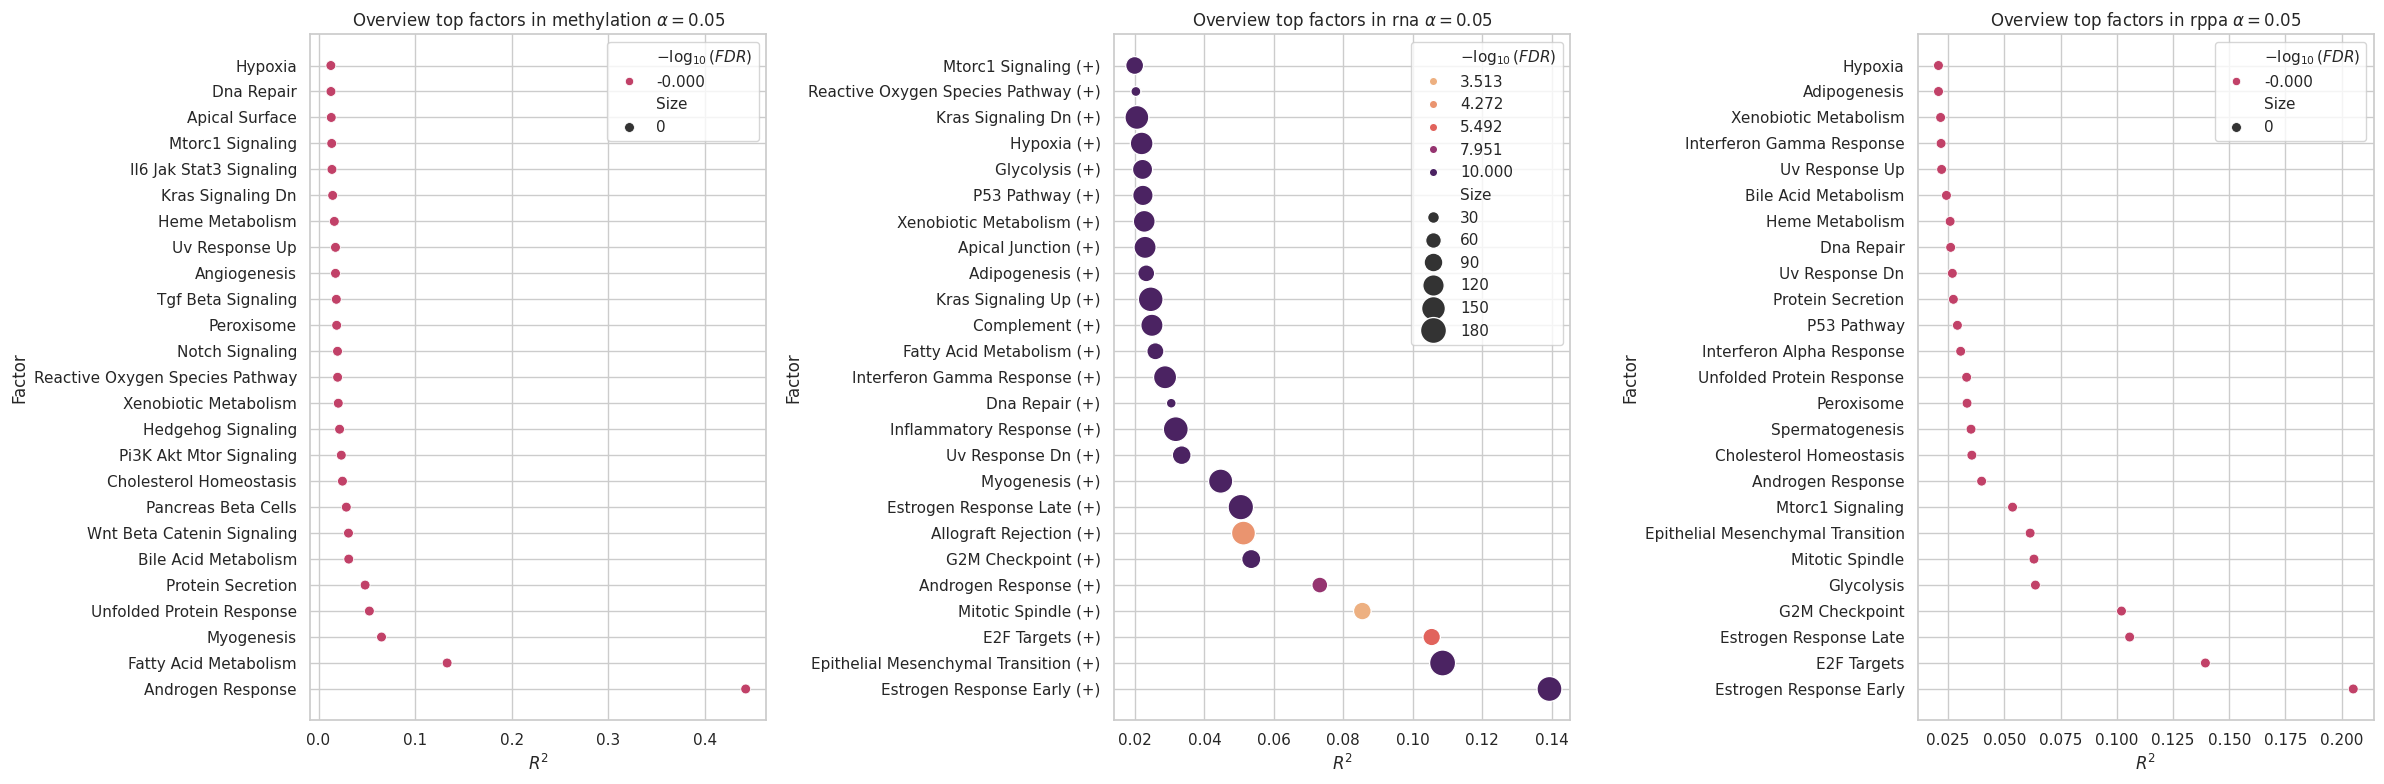

(<Figure size 2400x800 with 3 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in methylation $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in rppa $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [15]:
muvi.pl.factors_overview(model)

In [16]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [17]:
muvi.tl.filter_factors(model, r2_thresh=0.95)

2024-12-16 18:06:20,563 - muvi.tools.utils - INFO - Filtering down to 41 factors.
2024-12-16 18:06:20,566 - muvi.tools.cache - INFO - Factors filtered successfully.


True

In [18]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code_new/MuVI/muvi/tools/utils.py:817: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


In [19]:
model._cache.factor_adata.obs.columns

Index(['years_to_birth', 'vital_status', 'days_to_death',
       'days_to_last_followup', 'gender',
       'date_of_initial_pathologic_diagnosis', 'radiation_therapy', 'race',
       'ethnicity', 'ctype', 'leiden'],
      dtype='object')

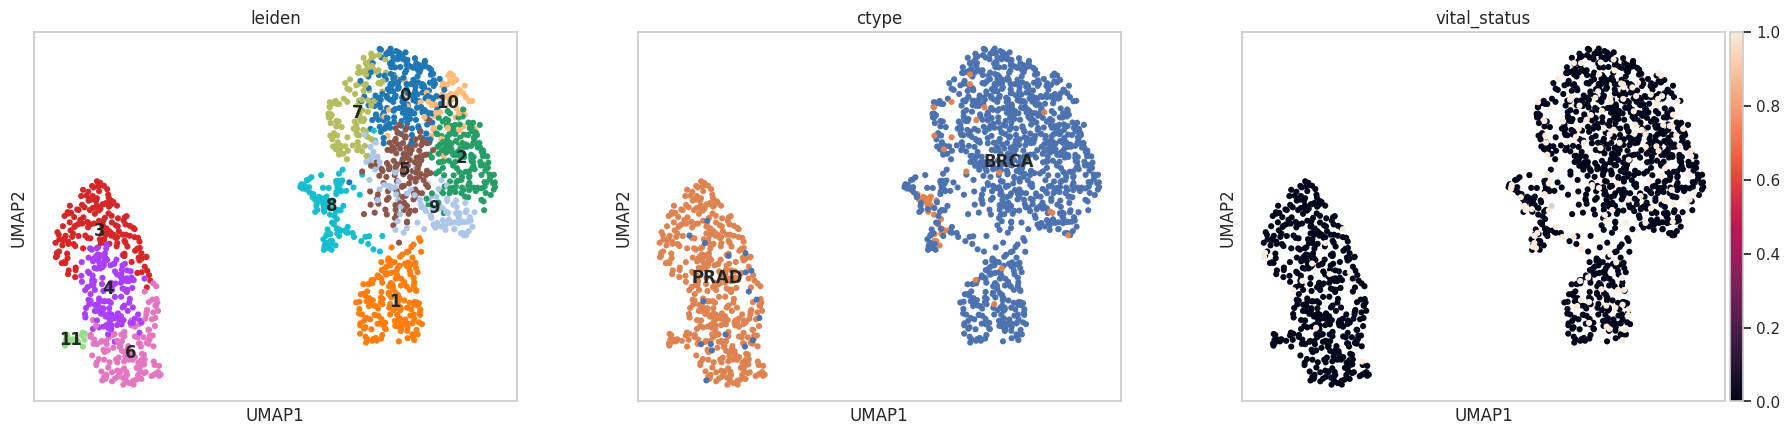

In [20]:
muvi.pl.umap(model, color=["leiden", "ctype", "vital_status"], legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [21]:
muvi.tl.rank(model, "ctype", method="wilcoxon")

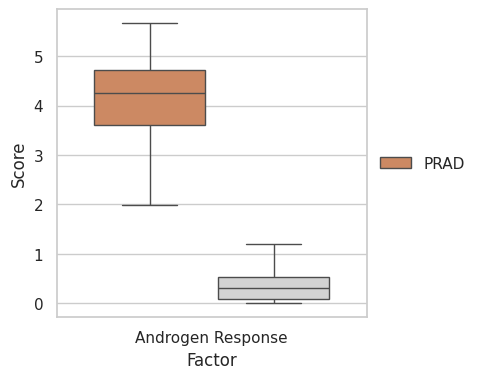

In [22]:
plt.figure(figsize=(4, 4))
relevant_factors, _ = muvi.pl.groupplot_rank(
    model, groups=["PRAD"], top=1, pl_type="boxplot", rot=0, gap=0.1, showfliers=False
)

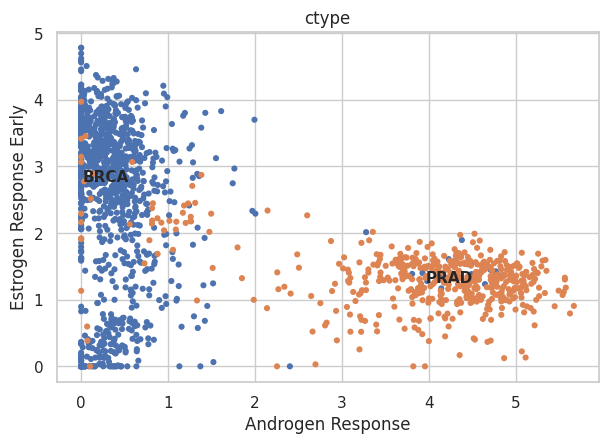

In [23]:
muvi.pl.scatter(model, x="Androgen Response", y="Estrogen Response Early", groupby="ctype", legend_loc="on data")

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

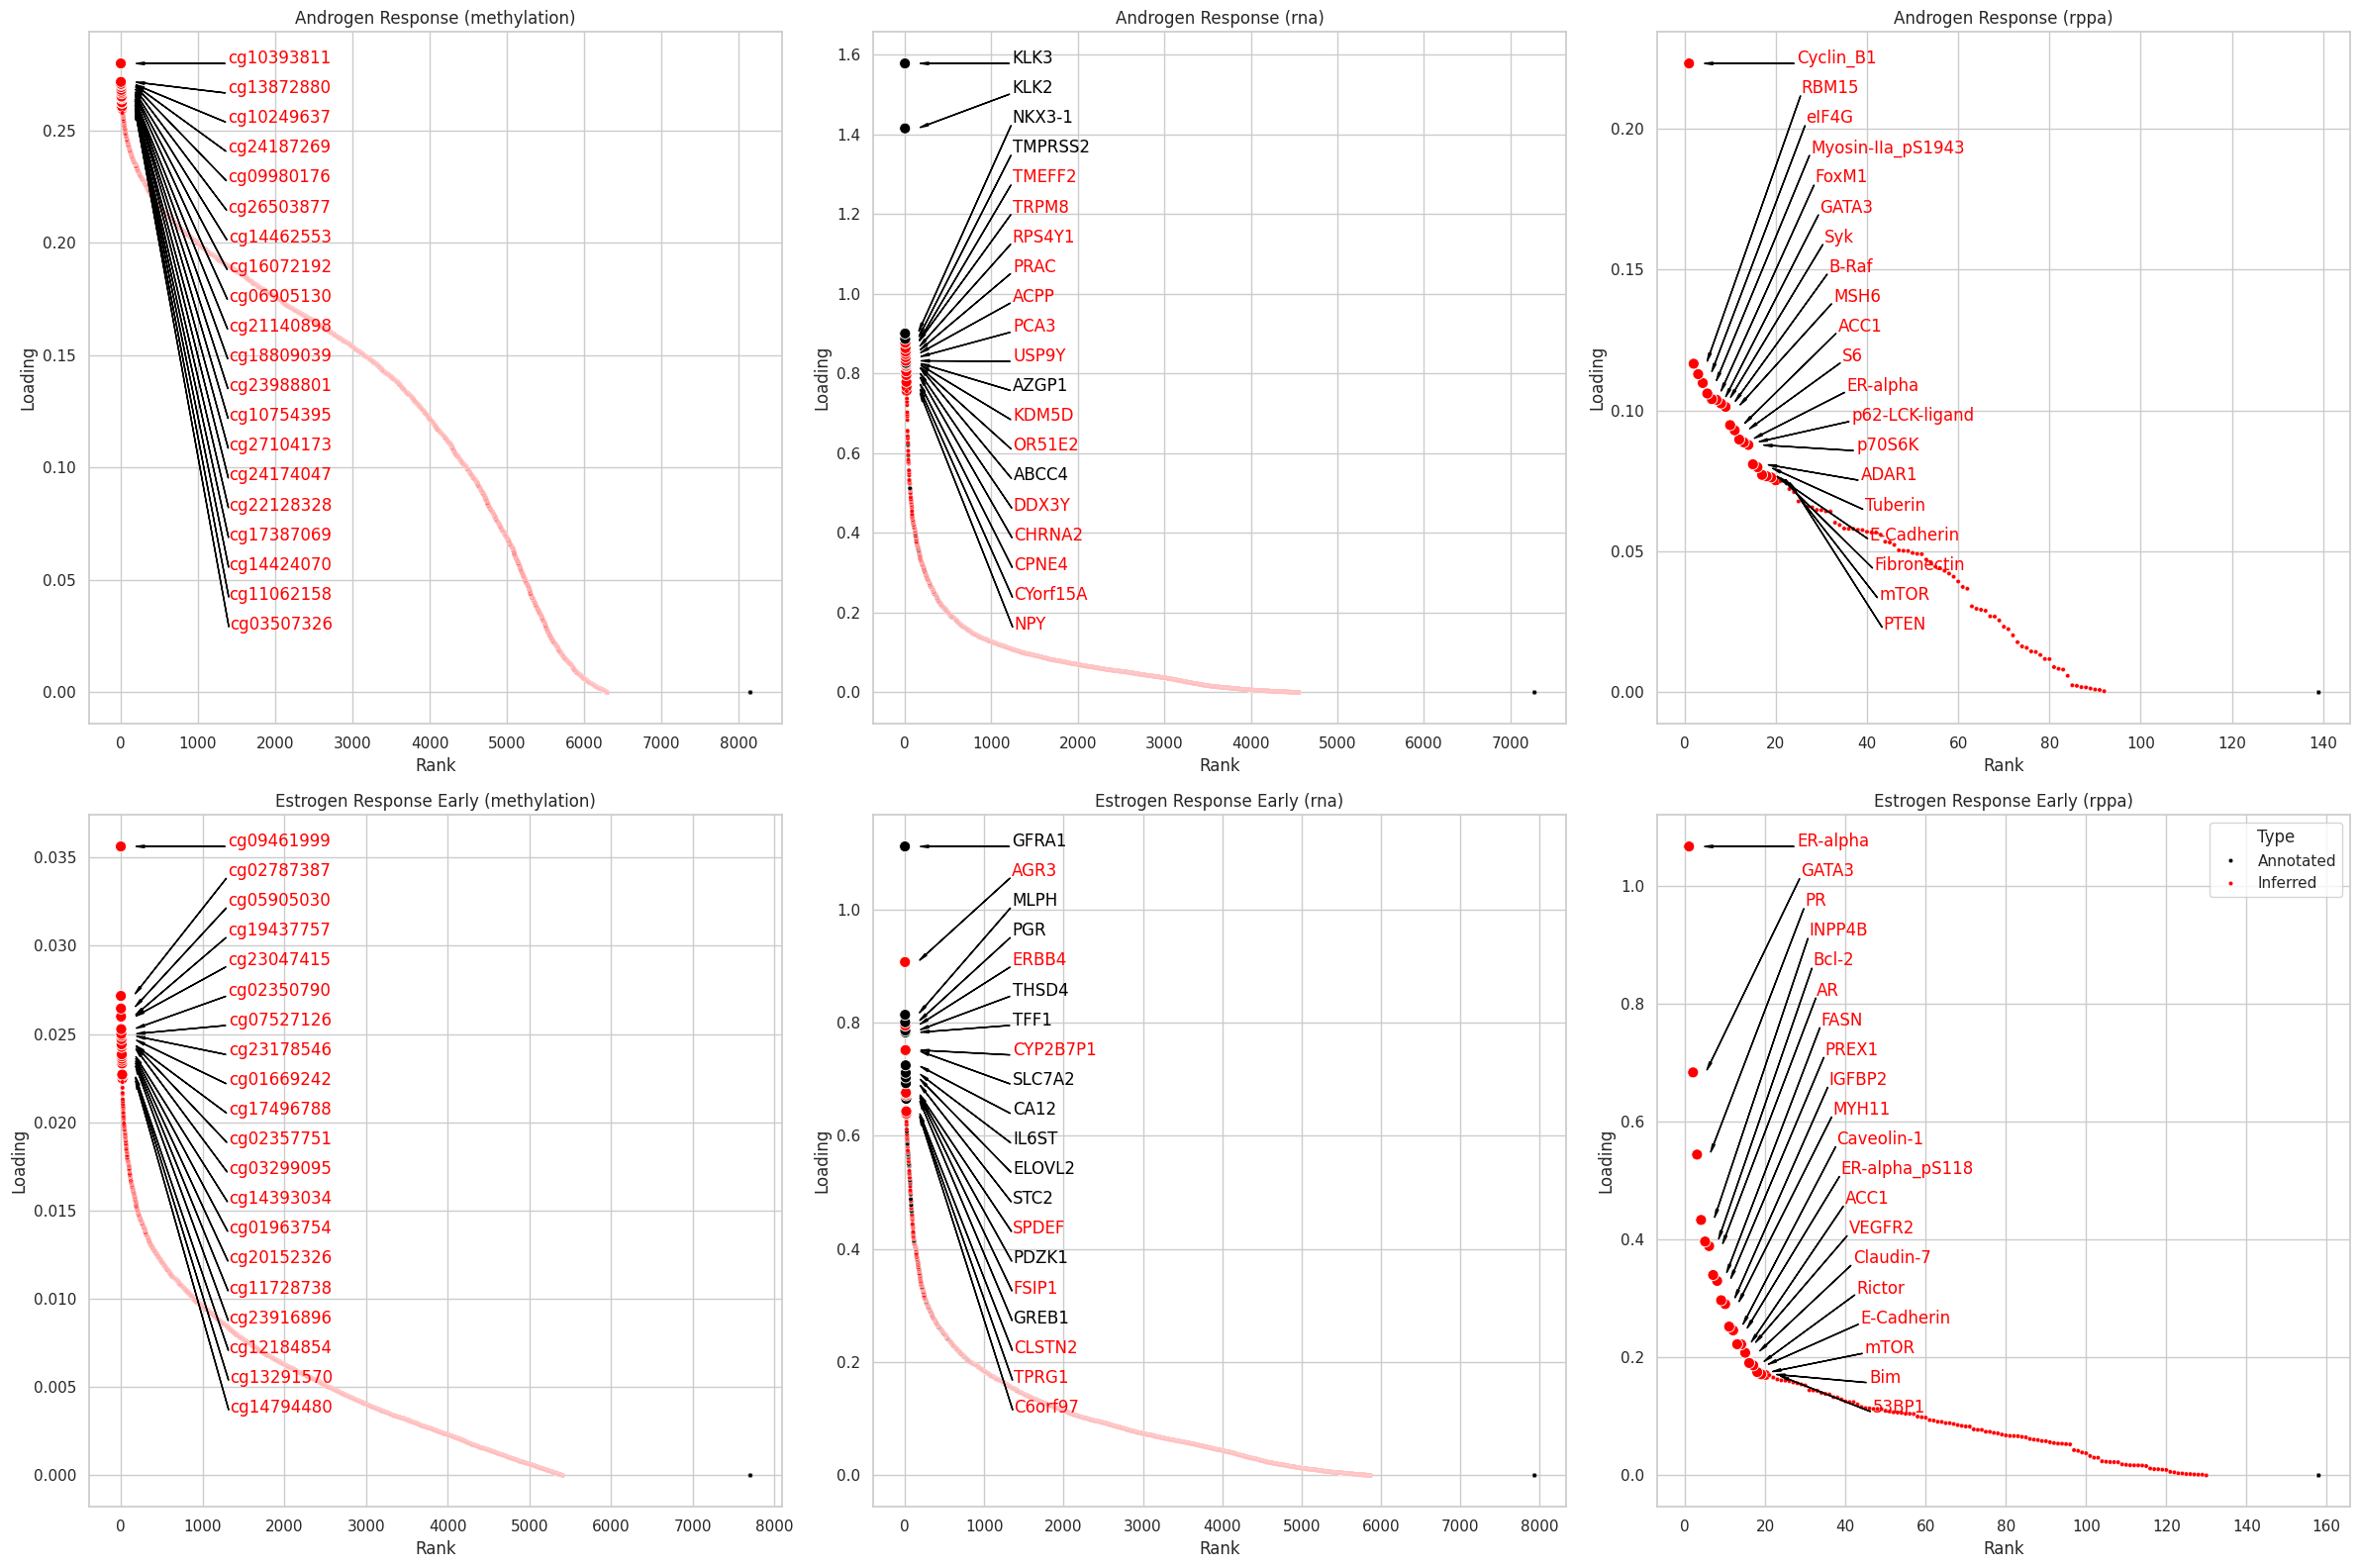

(<Figure size 2400x1600 with 6 Axes>,
 array([[<Axes: title={'center': 'Androgen Response (methylation)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Androgen Response (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Androgen Response (rppa)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'Estrogen Response Early (methylation)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Estrogen Response Early (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Estrogen Response Early (rppa)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

In [24]:
muvi.pl.inspect_factor(
    model,
    ["Androgen Response", "Estrogen Response Early"],
    top=20,
)

Finally, we may `save` the model on disk and `load` it later to resume the analysis.

In [25]:
# muvi.save(model, "some_model_output_directory")
# model = muvi.load("some_model_output_directory")